# Assignment 1: Tabular Methods

Name: Ajitesh Gupta

ID: A53220177

This exercise requires you to solve a simple grid-world problem called 'FrozenLake-v0' in OpenAI Gym.  We will solve the problem in two different ways. First we will solve the problem using dynamic programming, thus requiring a model of the system. Second we will do it using model-free temporal difference (Q-Learning). Finally, as a bonus you may also show it learning using a naive approach called hill-climbing. 

### Required for all 
#### Set up environment

In [87]:
%matplotlib inline
import gym
import numpy as np
from matplotlib import pyplot as plt
env = gym.make('FrozenLake-v0')
import pandas as pd

#### Pre. Test Policy Function
Write a function to test a policy. Return the average rate of successful episodes over 100 trials. 

In [88]:
def testPolicy(env, policy, n=100):
    #%% ---> start of code
    success = 0
    for i in range(n):
        obs = env.reset()
        done = False
        while not done:
            obs, rew, done, info = env.step(int(policy[obs]))
            if done:
                success+= rew
                break
    percentSuccess = 1.0*success/n
    #%% <--- end of code
    return percentSuccess

## Model-based Learning

### 1. Policy Iteration
Perform policy iteration on the Frozenlake example. 


#### 1.1 Find the system model
First, model $T(s,a,s')$ and $R(s,a,s')$ over 100000 randomly initializations.

In [90]:
def learnModel(n=100000):
    #%% ---> start of code
    nS = env.observation_space.n
    nA = env.action_space.n
    R = np.zeros((nS,nA,nS))
    T = np.zeros((nS,nA,nS))
    count = np.ones((nS,nA))
    
    for i in range(n):
        env.reset()
        for state in range(nS):
            for action in range(nA):
                env.env.s = state
                new_state, rew, done, info = env.step(action)
                R[state,action,new_state] += rew
                T[state,action,new_state] += 1.0
                count[state,action] += 1.0

    for s_i in range(nS):
        for a in range(nA):
            for s_j in range(nS):
                R[s_i,a,s_j] /= max(1,T[s_i,a,s_j])
                T[s_i,a,s_j] /= max(count[s_i,a],1)
    #%% <--- end of code
    return R,T

#first learn the model    
[R,T] = learnModel(100000)

#### 1.2 What does the transition model tell you about the stochastic behavior of actions? What does it tell you about the stochasticity  of the rewards? What would you expect an optimal agent's policy to do?

ans: 

In an ideal cases we would expect the agent to perform the action that it is instructed to perform, but this transition model shows us that that is not the case here. We see that it performs the wrong action with a certain probability. This helps us model a real life situation where agents might not behave as exepcted due to various sources of noise. This leads to more robust learning. 

The rewards function over here is pretty deterministic and is just objective based so we only get rewards at the end goal state and it is 0 everywhere else. If we were to make the agent go faster towards the goal we could provide small penalty for existence at each time step. This would lead the agent to the final goal faster.

The optimal agent's policy should be able to reach the goal state as fast as possible. But it should at the same time try to avoid going near the holes. This is because actions might misfire and hence being near a hole can lead to the hole even if the action did not specify it to go there. This way it would successfully complete the trip from start to end as many times as possible.

#### 1.3 Write a function for Policy Evaluation

In [91]:
#runPolicyEvaluation:
def runPolicyEvaluation(policy,V,R,T,discount_factor):
    #%% ---> start of code
    Vnew = np.zeros_like(V)
    for s in range(V.shape[0]):
        for sp in range(V.shape[0]):
            Vnew[s] += T[s,policy[s],sp] * ( R[s,policy[s],sp] + discount_factor*V[sp] )
    #%% <--- end of code
    return Vnew

def extractPolicy(V, R, T, discount_factor):
    nS = len(V)
    policy_new = [0]*nS
    for s in range(T.shape[0]):
        q_sa = np.zeros((4,1))
        for a in range(T.shape[1]):
            for sp in range(T.shape[2]):
                q_sa[a] += T[s,a,sp] * ( R[s,a,sp] + discount_factor*V[sp] )
        policy_new[s] = np.argmax(q_sa)
    return policy_new

#### 1.4 Run Policy iteration.
and show a bar graph of successful runs vs iteration on the policy. Use a discount factor of 0.98, and terminate policy  after 40 iterations of policy updates.  Plot the percentSuccesses at every iteration (i.e. the return of the testPolicy function).

('Policy iteration policy:', [0, 3, 0, 3, 0, 0, 2, 0, 3, 1, 0, 0, 0, 2, 1, 0])


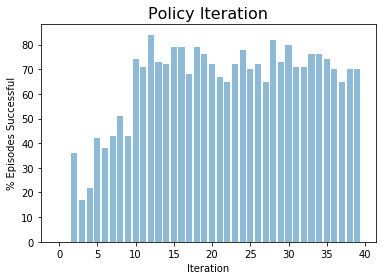

In [92]:
#%% ---> start of code
env.reset()
nS = env.observation_space.n
nA = env.action_space.n
discount_factor = 0.98
policy = np.random.randint(4,size=nS)
V = np.zeros(nS)
iters = 0
percentSuccesses = []
while iters<40:
    Vnew = runPolicyEvaluation(policy, V, R, T, discount_factor)
    policy_new = extractPolicy(Vnew, R, T, discount_factor)
    percentSuccesses.append(testPolicy(env,policy_new))
    V = Vnew
    policy = policy_new
    iters += 1
#%% <--- end of code
    
# plot improvement over time
plt.figure()
plt.bar(np.arange(len(percentSuccesses)), 100*np.array(percentSuccesses), align='center', alpha=0.5)
plt.ylabel('% Episodes Successful')
plt.xlabel('Iteration') 
plt.title('Policy Iteration',fontsize=16)  
print('Policy iteration policy:', policy)

## Model-Free Learning

### 2 Q Value-Iteration (Q-Learning)

#### 2.1 Set up a Q learning function
Set your exploration rate to 1-episode_num/total_num_of_episodes for linear convergence from completely random action selection to a greedy policy. Return a set of policies (at 5%, 10%,...100% of the total number of episodes) so that in the later section you can perform policy evaluation on intermediate Q-tables and show progress.

In [93]:
def runQLearning(env,learning_rate,discount_factor,num_of_episodes,Q0,explore_type='linear'):
    #%% code starts here
    #%% code ends here
    Q = Q0
    Q_saved = [Q0]
    stage = int(num_of_episodes/10)
    for episode in range(num_of_episodes):
        s = env.reset()
        while True:
            #env.render()
            # Exploration rate
            if explore_type=='linear':
                epsilon = 1 - 1.0*episode/num_of_episodes
            elif explore_type=='log':
                epsilon = 1000.0/(1000+episode)
                
            # Epsilon-Greedy policy
            max_a = np.argmax(Q[s,:])
            if np.random.rand()<1-epsilon:
                a = max_a
            else:
                actions = [i for i in range(env.action_space.n) if i!=max_a]
                a = np.random.choice(actions,1)[0]
                
            # Make a step
            s_new, rew, done, info = env.step(a)
            
            # Update Q-Values
            Q[s,a] += learning_rate*(rew + discount_factor*np.max(Q[s_new,:]) - Q[s,a])
            
            s = s_new
            
            # Break if reached end state
            if done:
                break
        
        # Store models at every 10%
        if (episode+1)%stage==0:
            Q_saved.append(Q.copy()) #save last Q
    return Q_saved

def getPolicyFromQ(Q):
    policy = np.random.randint(4,size=Q.shape[0])
    for state in range(Q.shape[0]):
        policy[state] = np.argmax(Q[state,:])
    return policy

#### 2.1 Perform Q-learning. 
Show policies during intermediate phases of Q-learning, at 0, 10%, 20%,...,100% of the total episodes during training. Set a learning rate of 0.98 and a discount factor of 0.95. Start with a zero-filled Q-table. Run 10000 episodes. Plot the bar graph of the success rate over time to visualize the improvements to success rate the new policies are providing. 

('Q-learning (linear) policy:', array([0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]))


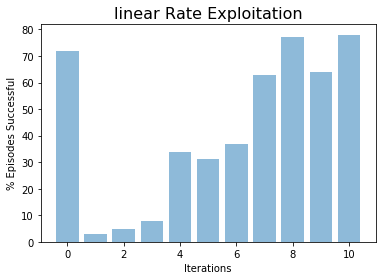

In [94]:
#%% ---> start of code
nS = env.observation_space.n
nA = env.action_space.n
Q0 = np.zeros((nS,nA))
Qs = runQLearning(env, 0.02, 0.95, 10000, Q0, 'linear')
percentSuccesses = []
policy = []
for Q in Qs:
    policy = getPolicyFromQ(Q)
    percentSuccesses.append(testPolicy(env,policy))
    
#%% <--- end of code

plt.figure()
plt.bar(np.arange(len(percentSuccesses)), 100*np.array(percentSuccesses), align='center', alpha=0.5)
plt.ylabel('% Episodes Successful')
plt.xlabel('Iterations')
plt.title('linear Rate Exploitation', fontsize=16)
print('Q-learning (linear) policy:', policy)

#### 1.4 Log Rate Exploration

Run Q-learning for a log exploration rate, $\frac{1000}{1000+\text{episode_num}}$, for 10,000 episodes. Perform policy evaluation and plot the success rate over time. You may find setting Q0 to a random number initialization helps (set it to something very small, i.e. 0.000001\*rand(), since setting it to zero sets a fixed seed).

('Q-learning (log) policy:', array([0, 3, 0, 3, 0, 1, 2, 3, 3, 1, 0, 3, 2, 2, 2, 2]))


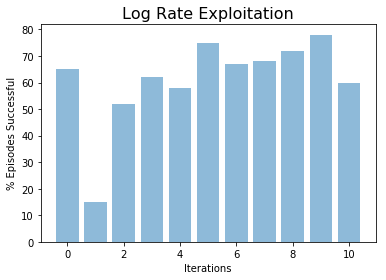

In [95]:
#%% ---> start of code
nS = env.observation_space.n
nA = env.action_space.n
Q0 = 0.000001*np.random.rand(nS,nA)
Qs = runQLearning(env, 0.02, 0.95, 10000, Q0, 'log')
percentSuccesses = []
policy = []
for Q in Qs:
    policy = getPolicyFromQ(Q)
    percentSuccesses.append(testPolicy(env,policy))
#%% <--- end of code

plt.figure()
plt.bar(np.arange(len(percentSuccesses)), 100*np.array(percentSuccesses), align='center', alpha=0.5)
plt.ylabel('% Episodes Successful')
plt.xlabel('Iterations')
plt.title('Log Rate Exploitation', fontsize=16)
print('Q-learning (log) policy:', policy)

### BONUS: Hill Climbing (25%, granted only if Parts 1 and 2 are complete)

Demonstrate hill climbing, where your Q values are chosen randomly, and you save improvements, with new Q values to try as $$Q_{test}\leftarrow Q_{best}+rand(S,A)$$
Plot the a bar graph with x-axis labelling the iteration number when an improvement occurred, and y axis as the % of successful episodes. Run on N = 1000 iterations of hill climbing, with 100 episodes per iteration. 

(array([3, 3, 2, 3, 0, 2, 2, 1, 2, 1, 0, 0, 2, 2, 2, 2]), ': Hill-climbing policy')


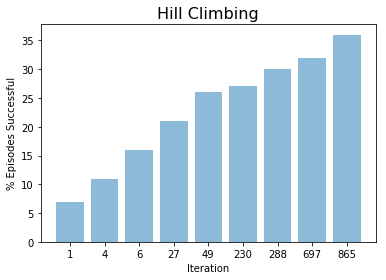

In [96]:
#%% ---> start of code
nS = env.observation_space.n
nA = env.action_space.n
Q = np.zeros((nS,nA))
improvementsIndex = []
percentSuccesses = []
best_success = 0.0
policy = []

for i in range(1000):
    randQ = 0.000001*np.random.rand(nS,nA)
    Qtest = Q + randQ
    
    test_policy = getPolicyFromQ(Qtest)
    test_success = testPolicy(env, test_policy)

    if test_success>best_success:
        best_success = test_success
        Q = Qtest
        policy = test_policy
        improvementsIndex.append(i)
        percentSuccesses.append(test_success)

#%% <--- end of code


plt.figure()
plt.bar(np.arange(len(improvementsIndex)), 100*np.array(percentSuccesses), align='center', alpha=0.5)
plt.xticks(np.arange(len(improvementsIndex)),improvementsIndex) 
plt.ylabel('% Episodes Successful')
plt.xlabel('Iteration')
plt.title('Hill Climbing',fontsize=16)
print(policy,': Hill-climbing policy')
